In [1]:
## LOAD MODULES ##
# Third Party
import sys
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
import datetime as dt
import metpy.calc as calc
from metpy.units import units
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
import pickle
from matplotlib.lines import Line2D
pd.plotting.deregister_matplotlib_converters()

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

###############################################################################################
# define class of pc_dict
class Point_coordinates:
    def __init__(self, shortname, name, color, marker, lat, lon, altitude, iconID, iconHSURF, iconHHL, iconHFL, height_dict):
        self.short = shortname
        self.name = name
        self.color = color
        self.marker = marker
        self.lat = lat
        self.lon = lon
        self.alt = altitude
        self.iconID = iconID 
        self.iconHSURF = iconHSURF
        self.iconHHL = iconHHL
        self.iconHFL = iconHFL
        self.hdict = height_dict 


# load pc_dict and its lists
pc_dict = np.load('../utilities_tlezuo/pc_dict.npy',allow_pickle=True).item()

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# get an overview of what is around
with open ('../utilities_tlezuo/pc_short_list','rb') as a:
    pc_short_list = pickle.load(a)
pc_short_list

['LAN',
 'IMS',
 'HAI',
 'ZUG',
 'KUF',
 'KIE',
 'ROS',
 'MUC',
 'ALP',
 'egg',
 'terf',
 'hoch',
 'kols',
 'weer',
 'arb',
 'RIN',
 'UNI',
 'ifl',
 'murs']

In [3]:
###############################################################################################
## DECIDE WHAT TO LOAD ##
# variables
spvars_list=[vf.T_2M,vf.VEL_10M,vf.DIR_10M,vf.P]#,vf.SW_d]
# location valley
loc_v = pc_dict['hoch']
stat_type_v = 'ibox' # toni, ibox
provider_v = 'acinn' #acinn, zamg, dwd
# location plain
loc_p = pc_dict['MUC']
stat_type_p = 'toni' # toni or ibox
provider_p = 'dwd' #UNI
# type of icon data: std, hf, int
icon_type = 'std' 

In [4]:
####################################### DATA function #######################################

def get_data(loc,stat_type,icon_type):
    ## LOAD DATA ICON TS ##
    if icon_type == 'std':# standard (15min)
        #run2
        ts_data_icon_RUN2 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN2_reference.nc')
        ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
        #run3
        ts_data_icon_RUN3 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN3_noconv.nc')
        ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
        #run4
        ts_data_icon_RUN4 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN4_cosmolev.nc')
        ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
    elif icon_type == 'hf': # high frequency (10s)
        #run2
        ts_data_icon_RUN2 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN2_reference.nc')
        ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.subsetID)
        #run3
        ts_data_icon_RUN3 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN3_noconv.nc')
        ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.subsetID)
        #run4
        ts_data_icon_RUN4 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN4_cosmolev.nc')
        ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.subsetID)

    for ts_data_icon in [ts_data_icon_RUN2,ts_data_icon_RUN3,ts_data_icon_RUN4]:
        ts_data_icon['VEL_10M'] = ts_data_icon['VEL_10m'] 
        ts_data_icon['DIR_10M'] = ts_data_icon['DIR_10m'] 
        ts_data_icon['T'] =     ts_data_icon['T'] -273.15

    ## LOAD DATA STATION ##

    if stat_type == 'ibox':
        ts_data_stat = gs.read_acinn(loc=loc, 
                            vars=spvars_list,
                            path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                            start_time = dt.datetime(2019,9,12,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                            end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                            correct_direction=True)
        ts_data_stat['dt'] = pd.to_datetime(ts_data_stat["timestamp"])
    else:
        ts_data_stat = np.load('/users/tlezuo/toni_codes/PLOTS/ts_stationdata.npy',allow_pickle='TRUE').item()
        ts_data_stat = ts_data_stat [loc.short]

    # explicit specification of variables for other stations
    if 'TL' in ts_data_stat.columns:
            T_str = 'TL'
            P_str = 'P'
            VEL_str = 'FF'
            DIR_str = 'DD'

    elif 't_K' in ts_data_stat.columns:
            T_str = 't_K'
            P_str = 'p_hPa'
            VEL_str = 'ws_ms'
            DIR_str = 'wd_deg'

    elif 'TT_10' in ts_data_stat.columns:
            T_str = 'TT_10'
            P_str = 'PP_10'
            VEL_str = 'FF_10'
            DIR_str = 'DD_10'

    elif 'T_2M' in ts_data_stat.columns:
            T_str = 'T_2M'
            P_str = 'P'  
            VEL_str = 'VEL_10M'
            DIR_str = 'DIR_10M'

    ts_data_stat['time']=ts_data_stat.index
    return ts_data_icon_RUN2,ts_data_icon_RUN3,ts_data_icon_RUN4,ts_data_stat,T_str,P_str,VEL_str,DIR_str


In [5]:
## LOAD DATA ICON TS PLAIN ##
ts_data_icon_p,ts_data_icon_RUN3_p,ts_data_icon_RUN4_p,ts_data_stat_p,T_str_p,P_str_p,VEL_str_p,DIR_str_p = get_data(loc_p,stat_type_p,icon_type)
## LOAD DATA ICON TS VALLEY ##
ts_data_icon_v,ts_data_icon_RUN3_v,ts_data_icon_RUN4_v,ts_data_stat_v,T_str_v,P_str_v,VEL_str_v,DIR_str_v = get_data(loc_v,stat_type_v,icon_type)

3 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found P as p in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found P as p in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_S2017_cf922acc/data.csv
Index(['columns: T_2M', 'columns: VEL_10M', 'columns: DIR_10M', 'columns: P',
       'columns: timestamp'],
      dtype='object')


In [6]:
ts_data_stat_v[P_str_v].resample('1h').interpolate('cubic')#-ts_data_stat_p[P_str_p]

rawdate
2019-09-12 12:00:00    NaN
2019-09-12 13:00:00    NaN
2019-09-12 14:00:00    NaN
2019-09-12 15:00:00    NaN
2019-09-12 16:00:00    NaN
2019-09-12 17:00:00    NaN
2019-09-12 18:00:00    NaN
2019-09-12 19:00:00    NaN
2019-09-12 20:00:00    NaN
2019-09-12 21:00:00    NaN
2019-09-12 22:00:00    NaN
2019-09-12 23:00:00    NaN
2019-09-13 00:00:00    NaN
2019-09-13 01:00:00    NaN
2019-09-13 02:00:00    NaN
2019-09-13 03:00:00    NaN
2019-09-13 04:00:00    NaN
2019-09-13 05:00:00    NaN
2019-09-13 06:00:00    NaN
2019-09-13 07:00:00    NaN
2019-09-13 08:00:00    NaN
2019-09-13 09:00:00    NaN
2019-09-13 10:00:00    NaN
2019-09-13 11:00:00    NaN
2019-09-13 12:00:00    NaN
2019-09-13 13:00:00    NaN
2019-09-13 14:00:00    NaN
2019-09-13 15:00:00    NaN
2019-09-13 16:00:00    NaN
2019-09-13 17:00:00    NaN
2019-09-13 18:00:00    NaN
2019-09-13 19:00:00    NaN
2019-09-13 20:00:00    NaN
2019-09-13 21:00:00    NaN
2019-09-13 22:00:00    NaN
2019-09-13 23:00:00    NaN
2019-09-14 00:00:00 

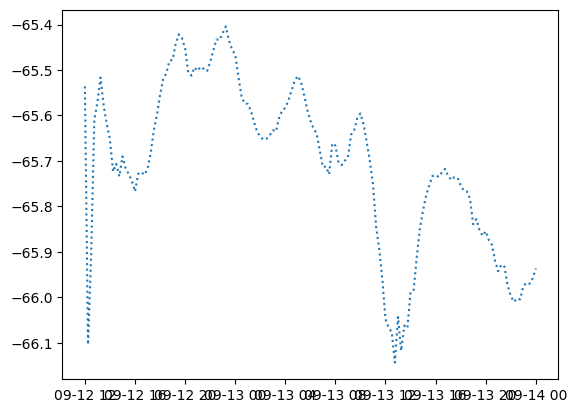

In [7]:
## FIRST PLOT OD delP
# plt.plot(ts_data_stat_v['P'].resample('10min').interpolate('cubic')-ts_data_stat_p['PP_10'],color='violet')
plt.plot(ts_data_stat_v[P_str_v].resample('10min').interpolate('cubic')-ts_data_stat_p[P_str_p],color='violet')
# plt.plot(ts_data_icon_v.time,ts_data_icon_v['PS']/100-ts_data_icon_p['PS']/100)
plt.plot(ts_data_icon_v.time,ts_data_icon_v['P']-ts_data_icon_p['P'],linestyle = 'dotted')


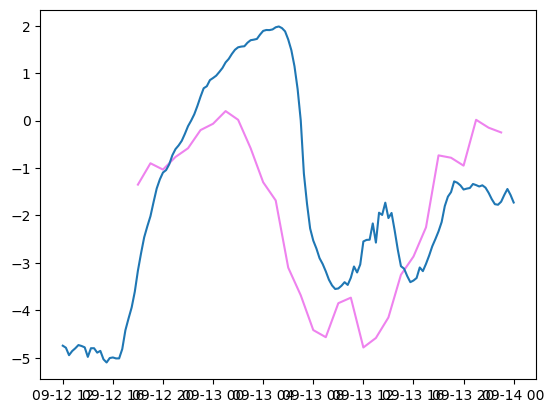

In [8]:
## FIRST PLOT OD delT
plt.plot(ts_data_stat_v[T_str_v].resample('1h').mean()-ts_data_stat_p[T_str_p].resample('1h').mean(),color='violet')
# plt.plot(ts_data_icon_v.time,ts_data_icon_v['PS']/100-ts_data_icon_p['PS']/100)
plt.plot(ts_data_icon_v.time,ts_data_icon_v['T']-ts_data_icon_p['T'])

(18151.666666666668, 18153.0)

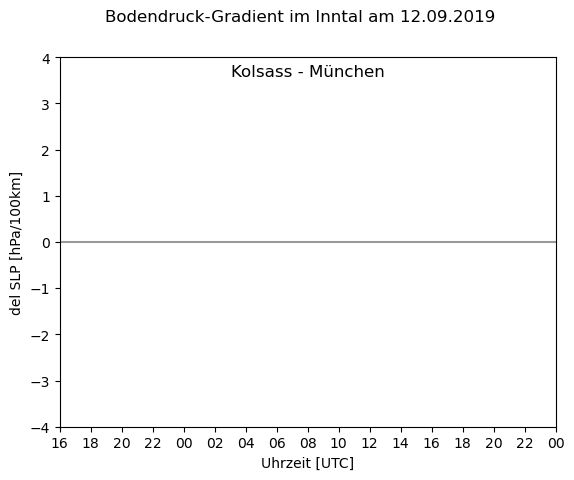

In [9]:
## P height corrected to SLP
# def P_to_SLP(P,T,h): # simplistic
#     H = np.full(len(P),h)
#     if T.mean()<200:
#         T=T+273.15
#     SLP = P*(1-(0.0065*H/(T+0.0065*H)))**(-5.257)
#     return SLP

def P_to_SLP(P,T,h): # theory based Wallace & Hobbs
    if T.mean()<200:
        T=T+273.15
    SLP = P*np.exp(h*9.81/(287*(T)))
    return SLP

SLP_stat_v = P_to_SLP(ts_data_stat_v[P_str_v].resample('1h').mean(),ts_data_stat_v[T_str_v].resample('1h').mean(),loc_v.alt)
SLP_stat_p = P_to_SLP(ts_data_stat_p[P_str_p].resample('1h').mean(),ts_data_stat_p[T_str_p].resample('1h').mean(),loc_p.alt)
SLP_model_v = P_to_SLP(ts_data_icon_v['P'],ts_data_icon_v['T'],loc_v.iconHSURF)
SLP_model_p = P_to_SLP(ts_data_icon_p['P'],ts_data_icon_p['T'],loc_p.iconHSURF)

startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,0,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)
# plt.plot(SLP_stat_p,color='violet')
# plt.plot(SLP_stat_v,color='violet',linestyle = 'dotted')
plt.plot(SLP_stat_v-SLP_stat_p,color='violet')
# plt.plot(ts_data_icon_v.time,SLP_model_v-SLP_model_p,color='dodgerblue')
plt.ylim(-4,4)
plt.title('Kolsass - München', y=1.0, pad=-14)
plt.suptitle('Bodendruck-Gradient im Inntal am 12.09.2019')
plt.ylabel('del SLP [hPa/100km]')
plt.xlim(dt.datetime(2019,9,12,18,00),enddate_plot)
plt.xlabel('Uhrzeit [UTC]')
plt.xticks(plotdates_plot[::],labels=[j.strftime('%H') for j in plotdates_plot[::]])
# ax[1,0].set_xticklabels([])
# plt.xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::]])
plt.hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)
plt.xlim(dt.datetime(2019,9,12,16,00),enddate_plot)


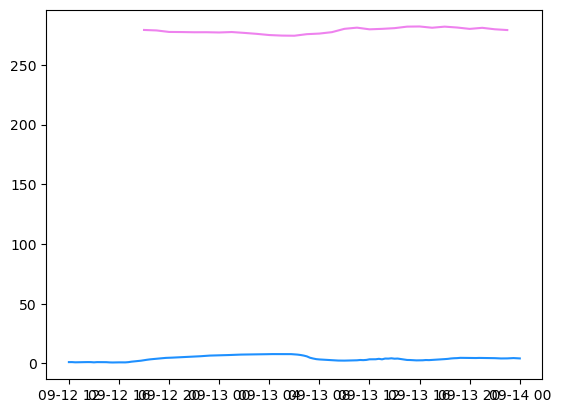

In [10]:
T_K_stat_v = ts_data_stat_v[T_str_v].resample('1h').mean() +273.15
T_K_stat_p =  ts_data_stat_p[T_str_p].resample('1h').mean() +273.15
T_K_model_v = ts_data_icon_v['T'] +273.15
T_K_model_p = ts_data_icon_p['T'] +273.15
TH_stat_v = vf.calculate_potT(T_K_stat_v,ts_data_stat_v[P_str_v].resample('1h').mean())
TH_stat_p = vf.calculate_potT(T_K_stat_p, ts_data_stat_p[P_str_p].resample('1h').mean())
TH_model_v = vf.calculate_potT(T_K_model_v, ts_data_icon_v['P'])
TH_model_p = vf.calculate_potT(T_K_model_p, ts_data_icon_p['P'])


plt.plot(TH_stat_v-TH_stat_p,color='violet')
plt.plot(ts_data_icon_v.time,TH_model_v-TH_model_p,color='dodgerblue')


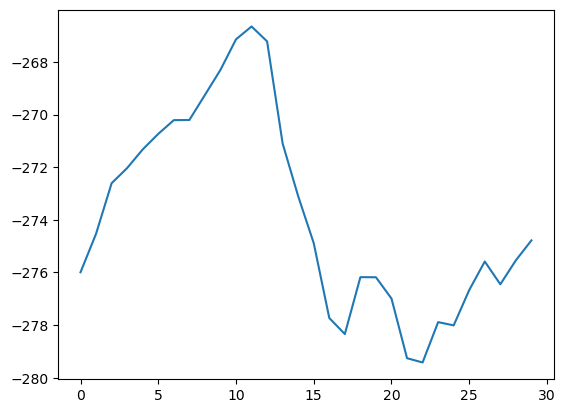

In [11]:
TH_stat_grad = TH_stat_v-TH_stat_p
TH_stat_grad
TH_stat_grad= TH_stat_grad[dt.datetime(2019,9,12,18): ]
TH_model_grad = TH_model_v-TH_model_p
TH_model_grad = TH_model_grad[24:].resample(time = '1H').mean()
TH_grad_bias = TH_model_grad - TH_stat_grad
plt.plot(TH_grad_bias)

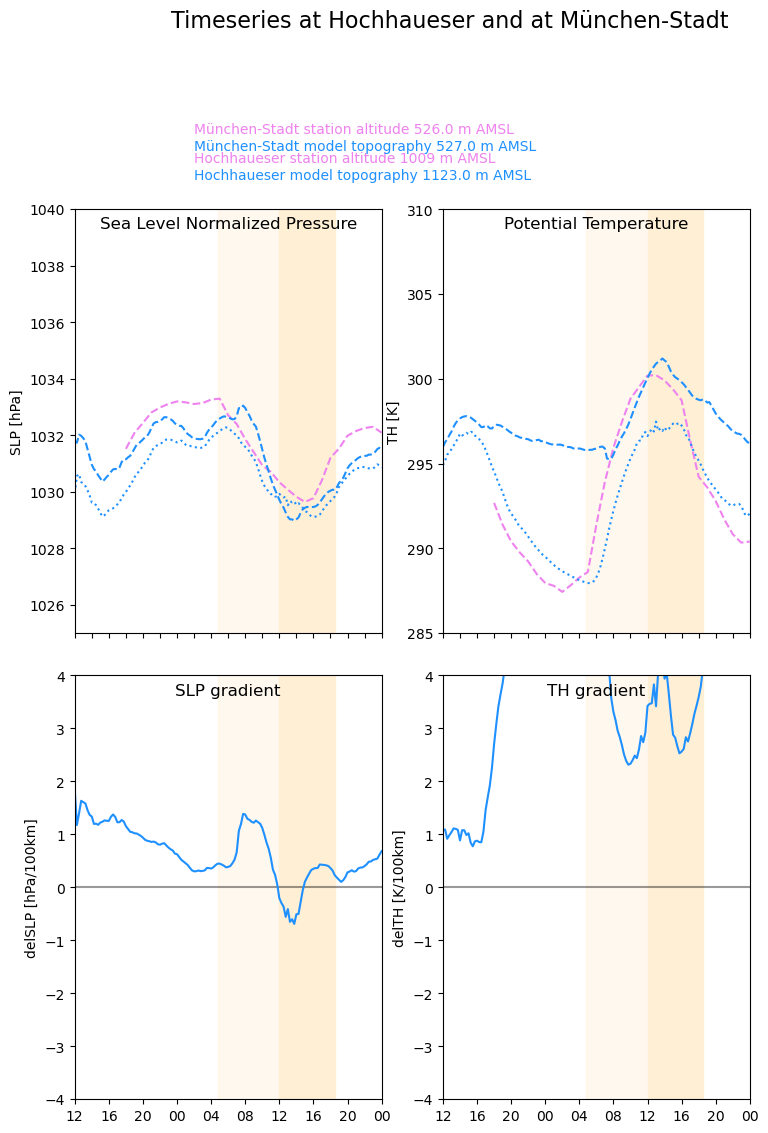

In [12]:
############################ plotting p, delp and TH, del TH #####################################
# time range
startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,0,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(2,2, figsize=(10,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle('Timeseries at '+loc_v.name + ' and at '+loc_p.name, fontsize=16, y=1.1)
ax[0,0].annotate(loc_v.name+' station altitude '+str(loc_v.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.11),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0,0].annotate(loc_p.name+' station altitude '+str(loc_p.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.18),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0,0].annotate(loc_v.name+' model topography '+str(loc_v.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')
ax[0,0].annotate(loc_p.name+' model topography '+str(loc_p.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.14),xycoords=('axes fraction','axes fraction'),color='dodgerblue')


########################## SLP ax00 #########################################
ax[0,0].plot(SLP_stat_p,color='violet',linestyle = 'dashed')
ax[0,0].plot(SLP_stat_v,color='violet',linestyle = 'dotted')
ax[0,0].plot(ts_data_icon_v.time,SLP_model_v, color='dodgerblue',linestyle = 'dashed')
ax[0,0].plot(ts_data_icon_p.time,SLP_model_p, color='dodgerblue',linestyle = 'dotted')

# options
ax[0,0].set_ylim(1025,1040)
ax[0,0].set_title('Sea Level Normalized Pressure', y=1.0, pad=-14)
ax[0,0].set_ylabel('SLP [hPa]')
ax[0,0].set_xlim(startdate_plot,enddate_plot)
ax[0,0].set_xticks(plotdates_plot)
ax[0,0].set_xticklabels([])
# ax[0,0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

########################## del SLP ax10 #########################################
ax[1,0].plot(SLP_stat_v-SLP_stat_p,color='violet')
ax[1,0].plot(ts_data_icon_v.time,SLP_model_v-SLP_model_p,color='dodgerblue')
# ax[1,0].fill_betweenx(ts_data_icon_v.time, SLP_model_v-SLP_model_p, SLP_stat_v-SLP_stat_p, where=(SLP_model_v-SLP_model_p > SLP_stat_v-SLP_stat_p), alpha=0.2, color='orangered')

# options
ax[1,0].set_ylim(-4,4)
ax[1,0].set_title('SLP gradient', y=1.0, pad=-14)
ax[1,0].set_ylabel('delSLP [hPa/100km]')
ax[1,0].set_xlim(startdate_plot,enddate_plot)
ax[1,0].set_xticks(plotdates_plot[::2])
# ax[1,0].set_xticklabels([])
ax[1,0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[1,0].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)

########################## TH ax01 #########################################
ax[0,1].plot(TH_stat_p,color='violet',linestyle = 'dashed')
ax[0,1].plot(TH_stat_v,color='violet',linestyle = 'dotted')
ax[0,1].plot(ts_data_icon_v.time,TH_model_v, color='dodgerblue',linestyle = 'dashed')
ax[0,1].plot(ts_data_icon_p.time,TH_model_p, color='dodgerblue',linestyle = 'dotted')

# options
ax[0,1].set_ylim(285,310)
ax[0,1].set_title('Potential Temperature', y=1.0, pad=-14)
ax[0,1].set_ylabel('TH [K]')
ax[0,1].set_xlim(startdate_plot,enddate_plot)
ax[0,1].set_xticks(plotdates_plot)
ax[0,1].set_xticklabels([])
# ax[0,0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
# ax[0,1].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)

########################## del TH ax10 #########################################
ax[1,1].plot(TH_stat_v-TH_stat_p,color='violet')
ax[1,1].plot(ts_data_icon_v.time,TH_model_v-TH_model_p,color='dodgerblue')

# options
ax[1,1].set_ylim(-4,4)
ax[1,1].set_title('TH gradient', y=1.0, pad=-14)
ax[1,1].set_ylabel('delTH [K/100km]')
ax[1,1].set_xlim(startdate_plot,enddate_plot)
ax[1,1].set_xticks(plotdates_plot[::2])
# ax[1,1].set_xticklabels([])
ax[1,1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[1,1].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)

########################## FILLING #########################################
# SUNRISE SUNSET
sunrise_time = dt.datetime(2019,9,13,4,48)
sunset_time = dt.datetime(2019,9,13,17,30)

ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)

# VW PERIOD
vw_start = dt.datetime(2019,9,13,12,0)
vw_end = dt.datetime(2019,9,13,18,30)
ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)

## BIAS


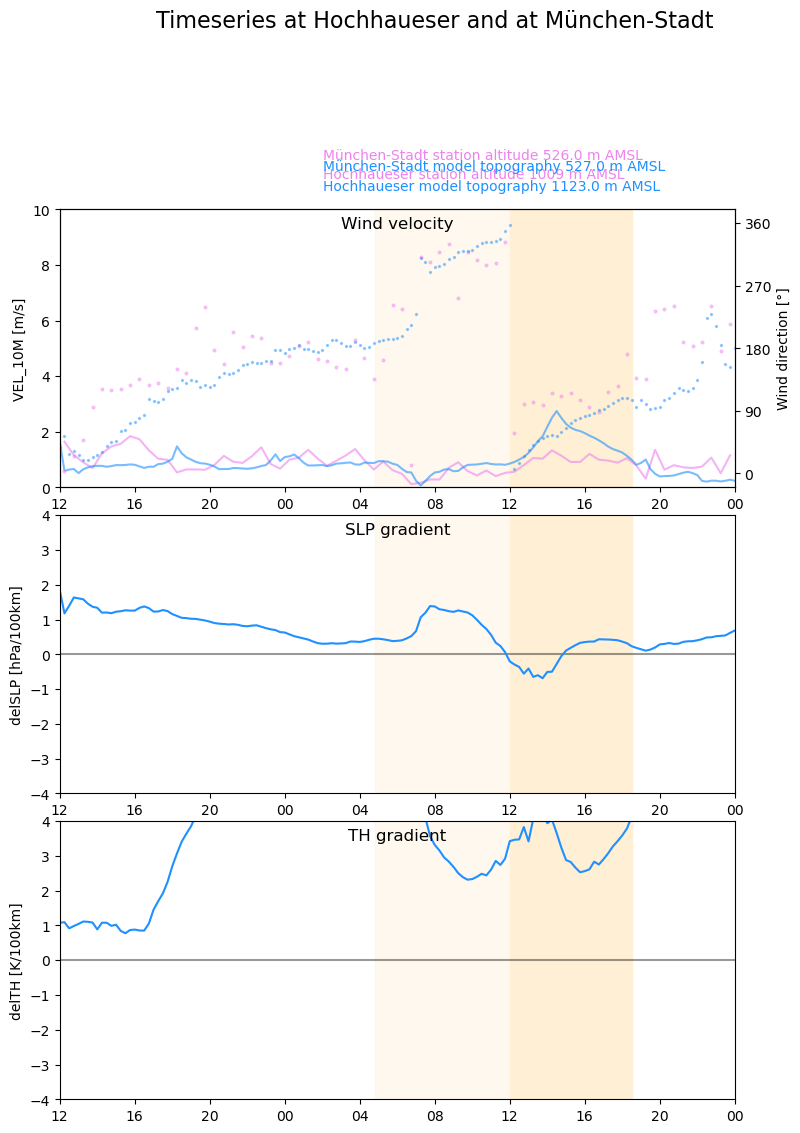

In [13]:
############################ plotting  delp,delTh and VEL to see correlations #####################################

# time range
startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,0,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(3,1, figsize=(10,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle('Timeseries at '+loc_v.name + ' and at '+loc_p.name, fontsize=16, y=1.1)
ax[0].annotate(loc_v.name+' station altitude '+str(loc_v.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.11),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0].annotate(loc_p.name+' station altitude '+str(loc_p.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.18),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0].annotate(loc_v.name+' model topography '+str(loc_v.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')
ax[0].annotate(loc_p.name+' model topography '+str(loc_p.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.14),xycoords=('axes fraction','axes fraction'),color='dodgerblue')

########################## VEL, DIR ax0 #########################################
# VEL
ax[0].plot(np.transpose(ts_data_stat_v[VEL_str_v]).dropna(),color='violet',alpha=0.6, label='observations')
ax[0].plot(ts_data_icon_v.time,ts_data_icon_v['VEL_10M'],color='dodgerblue',alpha=0.6, label='model')
# DIR
ax_ts_2 = ax[0].twinx()
ax_ts_2.scatter(ts_data_stat_v['time'],np.transpose(ts_data_stat_v[DIR_str_v]),color='violet',alpha=0.4,s=4) # station obs
ax_ts_2.scatter(ts_data_icon_v.time,ts_data_icon_v['DIR_10M'],color='dodgerblue',alpha=0.4,s=2)
ax_ts_2.set_ylim(-20,380)
ax_ts_2.set_yticks(np.arange(0,365,90))
ax_ts_2.set_ylabel('Wind direction [°]')
ax_ts_2.set_xlim(startdate_plot,enddate_plot)
ax_ts_2.set_xticks(plotdates_plot)

# options
ax[0].set_ylim(0,10)
ax[0].set_title('Wind velocity', y=1.0, pad=-14)
ax[0].set_ylabel('VEL_10M [m/s]')
ax[0].set_xlim(startdate_plot,enddate_plot)
ax[0].set_xticks(plotdates_plot[::2])
# ax[1,0].set_xticklabels([])
ax[0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])

########################## del SLP ax1 #########################################
ax[1].plot(SLP_stat_v-SLP_stat_p,color='violet')
ax[1].plot(ts_data_icon_v.time,SLP_model_v-SLP_model_p,color='dodgerblue')
# ax[1,0].fill_betweenx(ts_data_icon_v.time, SLP_model_v-SLP_model_p, SLP_stat_v-SLP_stat_p, where=(SLP_model_v-SLP_model_p > SLP_stat_v-SLP_stat_p), alpha=0.2, color='orangered')

# options
ax[1].set_ylim(-4,4)
ax[1].set_title('SLP gradient', y=1.0, pad=-14)
ax[1].set_ylabel('delSLP [hPa/100km]')
ax[1].set_xlim(startdate_plot,enddate_plot)
ax[1].set_xticks(plotdates_plot[::2])
# ax[1,0].set_xticklabels([])
ax[1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[1].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)


########################## del TH ax10 #########################################
ax[2].plot(TH_stat_v-TH_stat_p,color='violet')
ax[2].plot(ts_data_icon_v.time,TH_model_v-TH_model_p,color='dodgerblue')

# options
ax[2].set_ylim(-4,4)
ax[2].set_title('TH gradient', y=1.0, pad=-14)
ax[2].set_ylabel('delTH [K/100km]')
ax[2].set_xlim(startdate_plot,enddate_plot)
ax[2].set_xticks(plotdates_plot[::2])
# ax[1,1].set_xticklabels([])
ax[2].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[2].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)

########################## FILLING #########################################
# SUNRISE SUNSET
sunrise_time = dt.datetime(2019,9,13,4,48)
sunset_time = dt.datetime(2019,9,13,17,30)

ax[0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[2].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)

# VW PERIOD
vw_start = dt.datetime(2019,9,13,12,0)
vw_end = dt.datetime(2019,9,13,18,30)
ax[0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[2].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)


In [14]:
pc_short_list

['LAN',
 'IMS',
 'HAI',
 'ZUG',
 'KUF',
 'KIE',
 'ROS',
 'MUC',
 'ALP',
 'egg',
 'terf',
 'hoch',
 'kols',
 'weer',
 'arb',
 'RIN',
 'UNI',
 'ifl',
 'murs']

2 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Terfens_FLUX1_332b958e/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Terfens_FLUX1_332b958e/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Terfens_FLUX1_332b958e/data.csv
found P as pact in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Terfens_RAW_ed06922e/data.csv
Index(['columns: T_2M', 'columns: VEL_10M', 'columns: DIR_10M', 'columns: P',
       'columns: timestamp'],
      dtype='object')
6 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found P as pact 

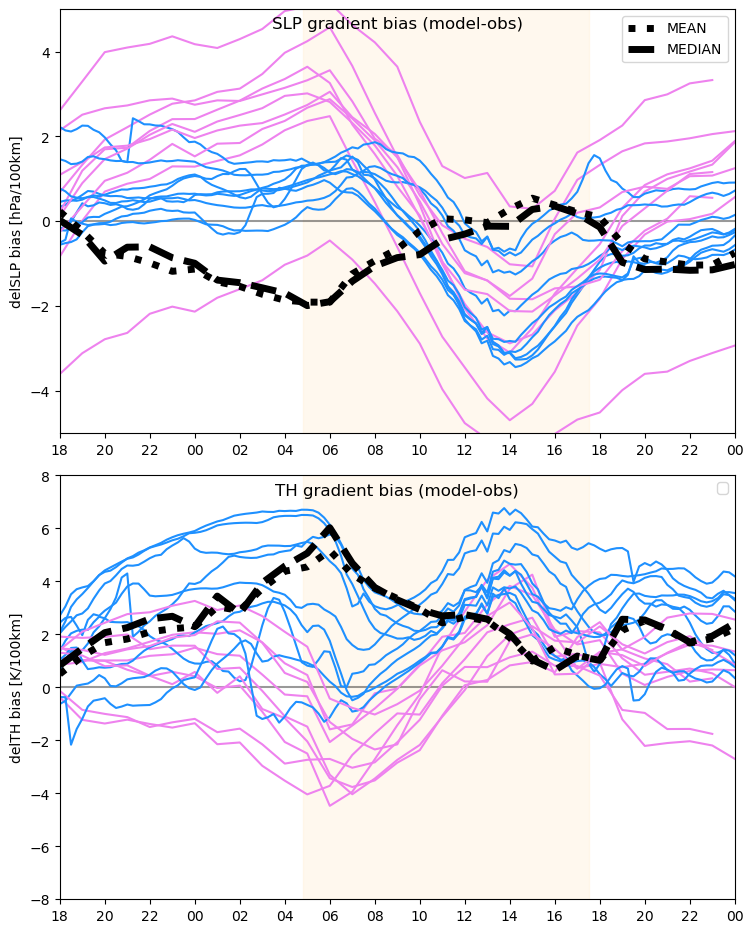

In [15]:
SLP_bias =pd.DataFrame()
TH_bias =pd.DataFrame()
# loc_v_str_list = pc_short_list[0:-2]
# loc_v_str_list.remove('hoch')
# loc_v_str_list.remove('ZUG')
loc_v_str_list = ['LAN','IMS','HAI','ALP','UNI',   'terf', 'kols','weer',         'RIN',]
stv_list = ['toni','toni','toni','toni','toni',    'ibox','ibox','ibox',         'toni']


# time range
startdate_plot = dt.datetime(2019,9,12,18,00)
enddate_plot = dt.datetime(2019,9,14,0,00)
plotfreq_plot = '1h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

fig, ax = plt.subplots(2,1, figsize=(10,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)

for loc_v_str, stv in zip(loc_v_str_list,stv_list):
    loc_v = pc_dict[loc_v_str]
    stat_type_v = stv
    # location plain
    loc_p = pc_dict['MUC']
    stat_type_p = 'toni' # toni or ibox

    ## LOAD DATA ICON TS PLAIN ##
    ts_data_icon_p,ts_data_icon_RUN3_p,ts_data_icon_RUN4_p,ts_data_stat_p,T_str_p,P_str_p,VEL_str_p,DIR_str_p = get_data(loc_p,stat_type_p,icon_type)
    ## LOAD DATA ICON TS VALLEY ##
    ts_data_icon_v,ts_data_icon_RUN3_v,ts_data_icon_RUN4_v,ts_data_stat_v,T_str_v,P_str_v,VEL_str_v,DIR_str_v = get_data(loc_v,stat_type_v,icon_type)
    # SLP
    SLP_stat_v = P_to_SLP(ts_data_stat_v[P_str_v].resample('1h').mean(),ts_data_stat_v[T_str_v].resample('1h').mean(),loc_v.alt)
    SLP_stat_p = P_to_SLP(ts_data_stat_p[P_str_p].resample('1h').mean(),ts_data_stat_p[T_str_p].resample('1h').mean(),loc_p.alt)
    SLP_model_v = P_to_SLP(ts_data_icon_v['P'],ts_data_icon_v['T'],loc_v.iconHSURF)
    SLP_model_p = P_to_SLP(ts_data_icon_p['P'],ts_data_icon_p['T'],loc_p.iconHSURF)
    SLP_stat_grad = SLP_stat_v-SLP_stat_p
    SLP_stat_grad= SLP_stat_grad[dt.datetime(2019,9,12,18): ]
    SLP_model_grad = SLP_model_v-SLP_model_p
    SLP_model_grad = SLP_model_grad[24:].resample(time = '1H').mean()
    SLP_grad_bias = SLP_model_grad - SLP_stat_grad
    SLP_bias[loc_v.short] = SLP_grad_bias

    # TH
    T_K_stat_v = ts_data_stat_v[T_str_v].resample('1h').mean() +273.15
    T_K_stat_p =  ts_data_stat_p[T_str_p].resample('1h').mean() +273.15
    T_K_model_v = ts_data_icon_v['T'] +273.15
    T_K_model_p = ts_data_icon_p['T'] +273.15
    TH_stat_v = vf.calculate_potT(T_K_stat_v,ts_data_stat_v[P_str_v].resample('1h').mean())
    TH_stat_p = vf.calculate_potT(T_K_stat_p, ts_data_stat_p[P_str_p].resample('1h').mean())
    TH_model_v = vf.calculate_potT(T_K_model_v, ts_data_icon_v['P'])
    TH_model_p = vf.calculate_potT(T_K_model_p, ts_data_icon_p['P'])
    TH_stat_grad = TH_stat_v-TH_stat_p
    TH_stat_grad= TH_stat_grad[dt.datetime(2019,9,12,18): ]
    TH_model_grad = TH_model_v-TH_model_p
    TH_model_grad = TH_model_grad[24:].resample(time = '1H').mean()
    TH_grad_bias = TH_model_grad - TH_stat_grad
    TH_bias[loc_v.short] = TH_grad_bias
    
    ########################## del SLP ax1 #########################################
    ax[0].plot(SLP_stat_v-SLP_stat_p,color='violet')
    ax[0].plot(ts_data_icon_v.time,SLP_model_v-SLP_model_p,color='dodgerblue')
    # ax[0].plot(plotdates_plot,SLP_grad_bias,label=loc_v.short)

    ########################## del TH ax10 #########################################
    ax[1].plot(TH_stat_v-TH_stat_p,color='violet')
    ax[1].plot(ts_data_icon_v.time,TH_model_v-TH_model_p,color='dodgerblue')
    # ax[1].plot(plotdates_plot,TH_grad_bias,label=loc_v.short)

########################## del SLP ax1 #########################################
# options
ax[0].set_ylim(-5,5)
ax[0].set_title('SLP gradient bias (model-obs)', y=1.0, pad=-14)
ax[0].set_ylabel('delSLP bias [hPa/100km]')
ax[0].set_xlim(startdate_plot,enddate_plot)
ax[0].set_xticks(plotdates_plot[::2])
ax[0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[0].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)

ax[0].plot(plotdates_plot,SLP_bias.mean(axis=1),color= 'k', linestyle = 'dotted',linewidth = 5,label = 'MEAN')
ax[0].plot(plotdates_plot,SLP_bias.median(axis=1),color= 'k', linestyle = 'dashed',linewidth = 5,label = 'MEDIAN')

########################## del TH ax10 #########################################
# options
ax[1].set_ylim(-8,8)
ax[1].set_title('TH gradient bias (model-obs)', y=1.0, pad=-14)
ax[1].set_ylabel('delTH bias [K/100km]')
ax[1].set_xlim(startdate_plot,enddate_plot)
ax[1].set_xticks(plotdates_plot[::2])
ax[1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::2]])
ax[1].hlines(y=0, xmin=startdate_plot, xmax=enddate_plot,colors='k',alpha=0.4)
ax[1].legend()
ax[1].plot(plotdates_plot,TH_bias.mean(axis=1),color= 'k', linestyle = 'dotted',linewidth = 5,label = 'MEAN')
ax[1].plot(plotdates_plot,TH_bias.median(axis=1),color= 'k', linestyle = 'dashed',linewidth = 5,label = 'MEDIAN')

ax[0].legend()

# SUNRISE SUNSET
sunrise_time = dt.datetime(2019,9,13,4,48)
sunset_time = dt.datetime(2019,9,13,17,30)

ax[0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
# ax[2].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
